<a href="https://colab.research.google.com/github/linhquetran/Melanoma/blob/main/Linh_Tran_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Melanoma Detection Assignment

Github link: https://github.com/linhquetran/Melanoma/edit/main/README.md

Importing all the important libraries:

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from glob import glob

Importing Skin Cancer Data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!ls -a /content/gdrive/MyDrive

 CNN_assignment.zip  'TAMUCC Diploma and transcript.pdf'
'Colab Notebooks'    'TAMUCC Transcript.pdf'


In [5]:
!unzip -a /content/gdrive/MyDrive/CNN_assignment.zip

Archive:  /content/gdrive/MyDrive/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  [binary]
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  [binary]
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  [binary]
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  [binary]
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  [binary]
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  [binary]
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  [binary]
  inflating: Skin cancer ISIC The International Skin Imaging Collaborati

##Data Reading

Define the path for train and test images

In [6]:
data_train=pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_test=pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

Check the number of extracted data

In [7]:
img_train = len(list(data_train.glob('*/*.jpg')))
print(img_train)
img_test = len(list(data_test.glob('*/*.jpg')))
print(img_test)

2239
118


##Dataset Creation


In [8]:
# Define the parameters: batch size of 32, resize images to 180*180
batch_size = 32
img_width = 180
img_height = 180

We divide the training set with 80% for training and 20% for validation

In [9]:
train_ds=tf.keras.utils.image_dataset_from_directory(
    data_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
val_ds=tf.keras.utils.image_dataset_from_directory(
    data_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List of all the classes of skin cancer
class_names=train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


##Dataset Visualization

This is a batch of 32 images with the size of 180*180. We write a code to visualize one instance of all the nine classes presented in the dataset.

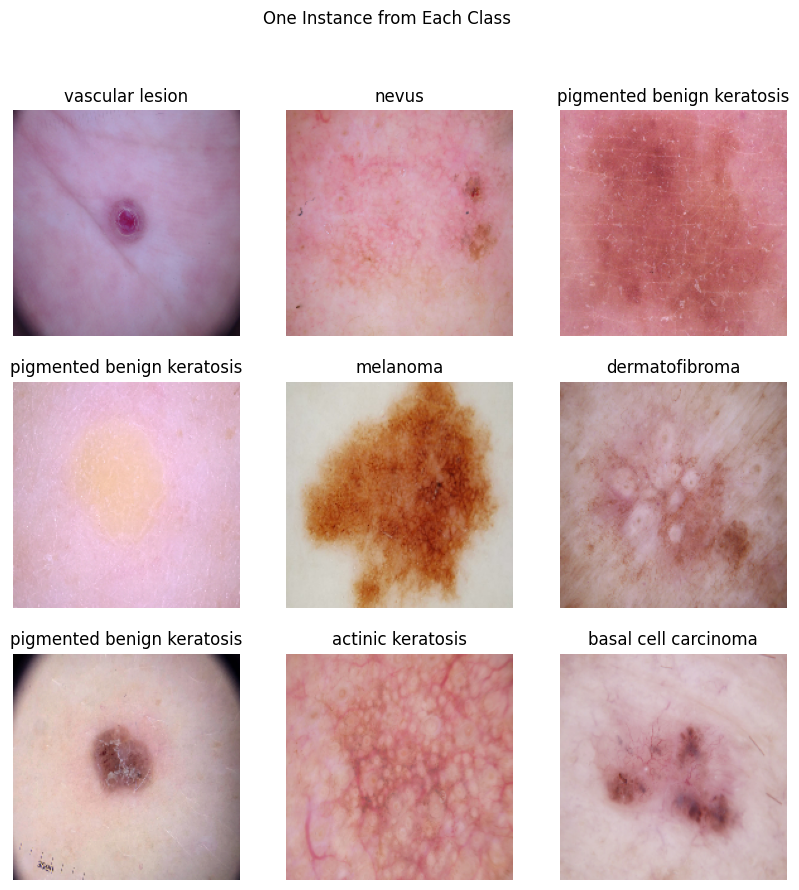

In [13]:
# Create a 3x3 image for displaying:
fig, axs = plt.subplots(3,3,figsize=(10,10))
fig.suptitle('One Instance from Each Class')

# Choose the first image from each class:
for image, instance in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(class_names[instance[i]])
    plt.axis("off")


##Model Building & training :

Configure dataset for further performance by using dataset.cache and dataset.prefetch

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

###Create the model

Rescaling the data for standardizing the RGB channel values to be within [0,1] range because the RGB channel values are in the [0,255] range, which is not ideal for a neural network.

In [15]:
rescaled_layer = layers.Rescaling(1./255)

In [16]:
rescaled_ds=train_ds.map(lambda x, y: (rescaled_layer(x),y))
images, labels = next(iter(rescaled_ds))
first_image=images[0]
print(np.min(first_image), np.max(first_image))

0.046078194 0.75817025


In [17]:
# Using Keras Sequential model:
number_class=len(class_names)

In [18]:
model = Sequential ([
    layers.Rescaling(1./255, input_shape = (img_height,img_width,3)),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(number_class)
])

###Compile the model

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

###Model Summary

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

###Train the model for ~20 epochs

In [21]:
epochs=20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/20
56/56 [==============================] - 18s 72ms/step - loss: 1.9145 - accuracy: 0.2919 - val_loss: 1.8985 - val_accuracy: 0.2953
Epoch 2/20
56/56 [==============================] - 1s 17ms/step - loss: 1.7244 - accuracy: 0.3778 - val_loss: 1.5133 - val_accuracy: 0.4899
Epoch 3/20
56/56 [==============================] - 1s 12ms/step - loss: 1.4487 - accuracy: 0.4916 - val_loss: 1.3829 - val_accuracy: 0.5011
Epoch 4/20
56/56 [==============================] - 1s 15ms/step - loss: 1.3341 - accuracy: 0.5279 - val_loss: 1.4304 - val_accuracy: 0.5235
Epoch 5/20
56/56 [==============================] - 1s 14ms/step - loss: 1.1788 - accuracy: 0.5854 - val_loss: 1.4452 - val_accuracy: 0.5503
Epoch 6/20
56/56 [==============================] - 1s 14ms/step - loss: 1.0778 - accuracy: 0.6110 - val_loss: 1.4840 - val_accuracy: 0.5369
Epoch 7/20
56/56 [==============================] - 1s 14ms/step - loss: 0.9987 - accuracy: 0.6557 - val_loss: 1.4173 - val_accuracy: 0.5302
Epoch 8/20
5

The number 56/56 shows that the training step is running through 56 batches. After 20 epochs, we can see that the validation accuracy is around 53%

In [22]:
# Visualize the training results:
# We will plot the loss and accuracy of the training and validation sets
accu = history.history['accuracy']
val_accu = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

e_range= range(epochs)

Text(0.5, 1.0, 'Training and Validation Loss')

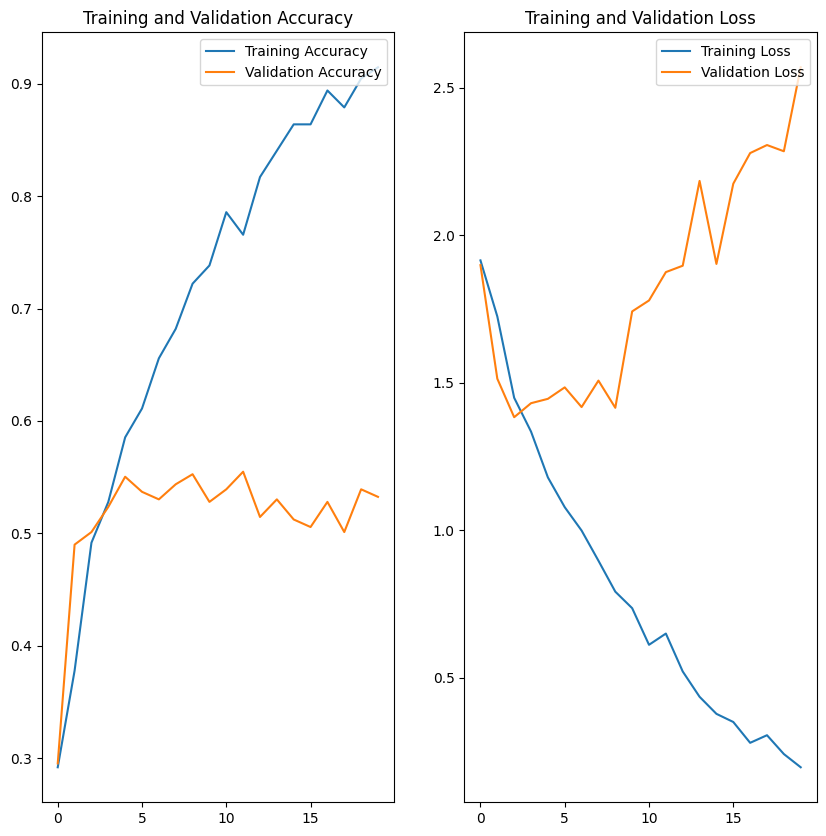

In [23]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(e_range,accu,label='Training Accuracy')
plt.plot(e_range,val_accu,label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(e_range,loss,label='Training Loss')
plt.plot(e_range,val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

The graph shows that the difference between training and validation accuracy is significant, which indicates the sign of overfitting. The model has difficulties to identify the major patterns in the data and generalize on a new dataset. As a result, we decide to use data augmentation and add dropout to the model.

###Data Augmentation

In [24]:
data_aug=keras.Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

Visualize how data augmentation strategy works for one instance of training image

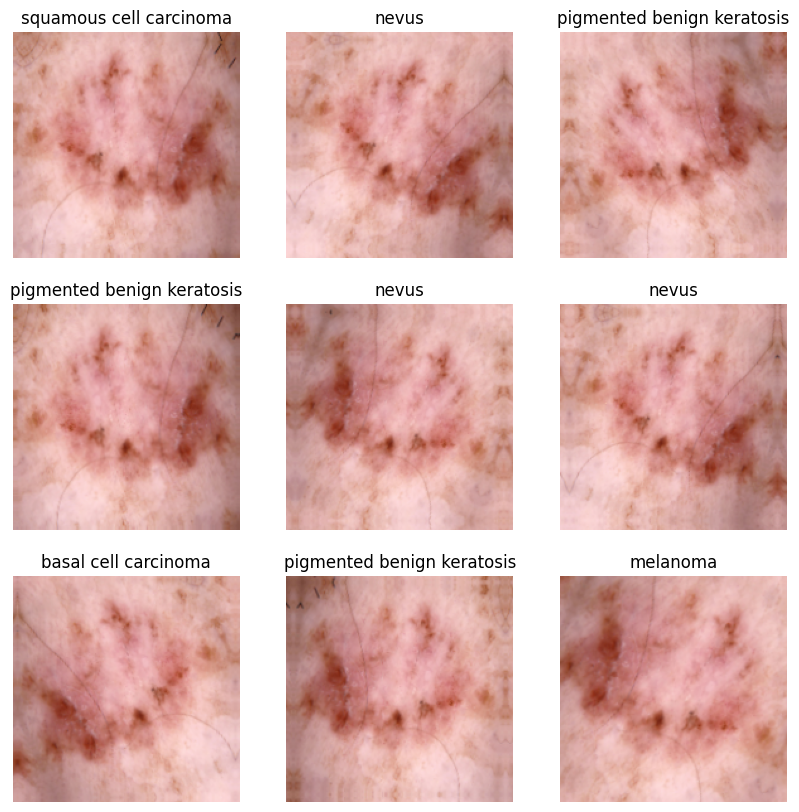

In [25]:
plt.figure(figsize=(10,10))
for image, instance in train_ds.take(1):
  for i in range(9):
    aug_img=data_aug(image)
    ax = plt.subplot(3,3,i+1)
    plt.imshow(aug_img[0].numpy().astype("uint8"))
    plt.title(class_names[instance[i]])
    plt.axis("off")

###Add Dropout

We decide to dropout 20% of the output units randomly from the layer during the training process.

In [32]:
model1 = Sequential ([
    data_aug,
    layers.Rescaling(1./255),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(number_class, name="outputs")
])

##Compile and train the model

In [33]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [35]:
epochs=20
history = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/20
56/56 [==============================] - 3s 19ms/step - loss: 2.0645 - accuracy: 0.2377 - val_loss: 1.9246 - val_accuracy: 0.2304
Epoch 2/20
56/56 [==============================] - 1s 18ms/step - loss: 1.7481 - accuracy: 0.3683 - val_loss: 1.7202 - val_accuracy: 0.3624
Epoch 3/20
56/56 [==============================] - 1s 17ms/step - loss: 1.5926 - accuracy: 0.4330 - val_loss: 1.5220 - val_accuracy: 0.4474
Epoch 4/20
56/56 [==============================] - 1s 18ms/step - loss: 1.5364 - accuracy: 0.4604 - val_loss: 1.4875 - val_accuracy: 0.4877
Epoch 5/20
56/56 [==============================] - 1s 20ms/step - loss: 1.4479 - accuracy: 0.4950 - val_loss: 1.4714 - val_accuracy: 0.5011
Epoch 6/20
56/56 [==============================] - 1s 21ms/step - loss: 1.4180 - accuracy: 0.4905 - val_loss: 1.4686 - val_accuracy: 0.4877
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 1.3397 - accuracy: 0.5251 - val_loss: 1.3389 - val_accuracy: 0.5391
Epoch 8/20
56

In [36]:
# Visualize the training results:
# We will plot the loss and accuracy of the training and validation sets
accu = history.history['accuracy']
val_accu = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

e_range= range(epochs)

Text(0.5, 1.0, 'Training and Validation Loss')

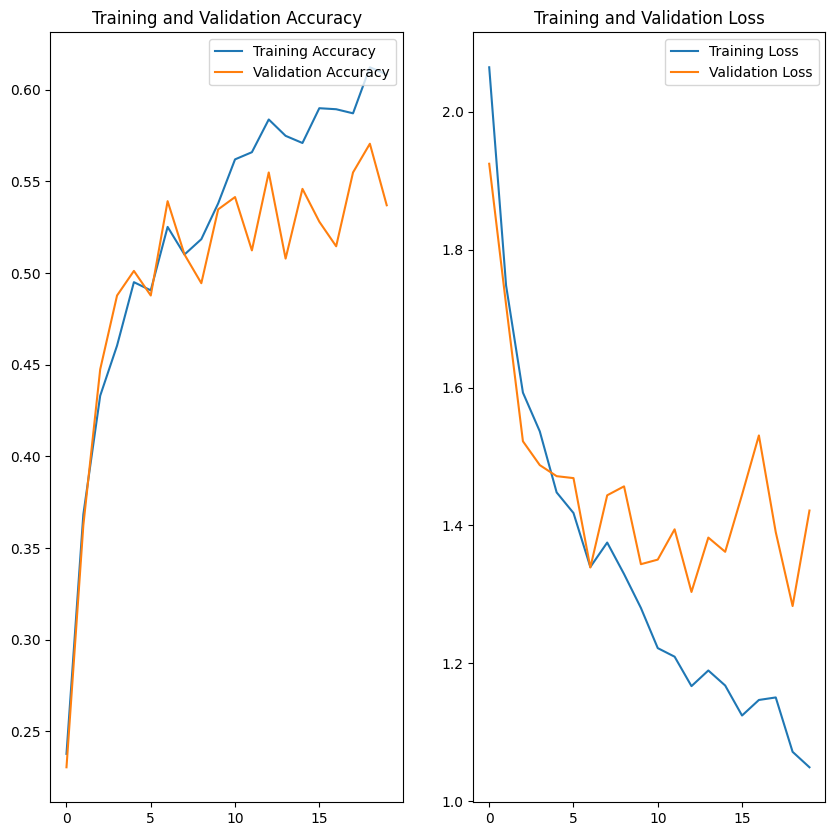

In [37]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(e_range,accu,label='Training Accuracy')
plt.plot(e_range,val_accu,label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(e_range,loss,label='Training Loss')
plt.plot(e_range,val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

After using the data augmentation and add dropout, the overfitting becomes less than precious model. In addition, the training accuracy and loss are more aligned to the validation accuracy and loss (respectively)

##Class distributions

In [43]:
class_counts = {}
for class_name in os.listdir(data_train):
  class_folder=os.path.join(data_train,class_name)
  if os.path.isdir(class_folder):
    num_images=len(os.listdir(class_folder))
    class_counts[class_name]=num_images

In [44]:
 # class has the least number of samples:
 min_class=min(class_counts, key=class_counts.get)
 min_samples = class_counts[min_class]

In [45]:
# Proportion of samples for each class:
total_samples=sum(class_counts.values())
class_proportions = {class_name: count/total_samples for class_name, count in class_counts.items()}
dominate_class=[class_name for class_name in class_proportions if class_proportions[class_name]>0.1]

In [46]:
print("Class distributions:")
for class_name, count in class_counts.items():
  print(f"{class_name}:{count} samples")
print ("\nClass has the least number of samples:", min_class)
print ("\nClasses dominate the data in terms proportionate number of samples:", dominate_class)

Class distributions:
dermatofibroma:95 samples
melanoma:438 samples
pigmented benign keratosis:462 samples
basal cell carcinoma:376 samples
squamous cell carcinoma:181 samples
seborrheic keratosis:77 samples
vascular lesion:139 samples
nevus:357 samples
actinic keratosis:114 samples

Class has the least number of samples: seborrheic keratosis

Classes dominate the data in terms proportionate number of samples: ['melanoma', 'pigmented benign keratosis', 'basal cell carcinoma', 'nevus']


There is class imbalance in the dataset where some classes have around 400 (such as "pigmented benign keratosis" and "basal cell carcinoma" samples while some classes have less than 100 samples (such as "dermatofibroma" with 95 samples and "seborrheic keratosis" with just 77 samples)

##Handling class imbalances:

Rectify class imbalances present in the training dataset with Augmentor library.

In [47]:
!pip install Augmentor

In [60]:
from pathlib import Path
import Augmentor

In [61]:
# List of class names and their paths:
class_paths = {
    "actinic keratosis": Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis"),
    "basal cell carcinoma": Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma"),
    "dermatofibroma": Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma"),
    "melanoma": Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma"),
    "nevus": Path ("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus"),
    "pigmented benign keratosis": Path ("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis"),
    "seborrheic keratosis": Path ("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis"),
    "squamous cell carcinoma": Path ("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma"),
    "vascular lesion": Path ("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion"),
}

In [65]:
for class_name, class_path in class_paths.items():
  pipeline=Augmentor.Pipeline(str(class_path))
  pipeline.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
  pipeline.flip_left_right(probability=0.5)
  pipeline.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AB49CD590F0>: 100%|██████████| 500/500 [00:16<00:00, 30.81 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AB553C9D780>: 100%|██████████| 500/500 [00:13<00:00, 36.93 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AB5300D2080>: 100%|██████████| 500/500 [00:15<00:00, 33.14 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7AB49D123460>: 100%|██████████| 500/500 [01:12<00:00,  6.94 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7AB49D14D930>: 100%|██████████| 500/500 [01:06<00:00,  7.52 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AB548587D30>: 100%|██████████| 500/500 [00:14<00:00, 35.17 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7AB54856F1C0>: 100%|██████████| 500/500 [00:30<00:00, 16.43 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AB49D1CB970>: 100%|██████████| 500/500 [00:13<00:00, 38.10 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AB49CDE27A0>: 100%|██████████| 500/500 [00:12<00:00, 38.61 Samples/s]


Total count of augmented images

In [66]:
image_count_train = len(list(data_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


 The distribution of augmented data after adding new images to the original training data.

In [67]:

path_list = [x for x in glob(os.path.join(data_train, '*','output', '*.jpg'))]
path_list

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027044.jpg_c2dd9f34-f692-4b77-9a07-b4c1a7274381.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029891.jpg_abc8440a-b87a-45fc-9674-165fc997defc.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025954.jpg_61dfd342-05f5-43e4-8de2-cbc195542c0f.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029177.jpg_42ad7b72-b572-431d-b73f-261a3daf77aa.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025771.jpg_8dde8435-85c1-4712-9dee-5904cc62f3e9.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Tr

In [68]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_train, '*','output', '*.jpg'))]
lesion_list_new

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [70]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [85]:
#Convert data_train Path to string:
data_train_str=[str(path) for path in class_paths]

In [86]:
#Create the Dataframe:
df=pd.DataFrame({'File_Path': data_train_str})

In [87]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df.append(df2)

<ipython-input-87-2c0c1bf59e38>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = df.append(df2)


In [88]:
new_df['Label'].value_counts()

dermatofibroma                500
melanoma                      500
pigmented benign keratosis    500
basal cell carcinoma          500
squamous cell carcinoma       500
seborrheic keratosis          500
vascular lesion               500
nevus                         500
actinic keratosis             500
Name: Label, dtype: int64

Now, all classes have been added 500 samples and obtain class balance.

###Train the model on the data created using Augmentor

In [89]:
batch_size = 32
img_height = 180
img_width = 180

###Create a training dataset

In [108]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [110]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


##Create the model (include normalization)

In [120]:
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, Dropout, Flatten, MaxPooling2D

In [121]:
#Define the parameters:
batch_size = 32
num_classes = 9
epochs = 30

In [122]:
model = Sequential ([
    layers.Rescaling(1./255, input_shape = (img_height,img_width,3)),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(number_class)
])

##Compile the model

In [123]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

##Train your model

In [124]:
epochs=30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/30
169/169 [==============================] - 35s 187ms/step - loss: 2.2765 - accuracy: 0.3344 - val_loss: 24.8536 - val_accuracy: 0.1180
Epoch 2/30
169/169 [==============================] - 34s 196ms/step - loss: 1.5045 - accuracy: 0.4271 - val_loss: 17.7018 - val_accuracy: 0.1544
Epoch 3/30
169/169 [==============================] - 39s 229ms/step - loss: 1.2989 - accuracy: 0.4794 - val_loss: 3.7622 - val_accuracy: 0.2539
Epoch 4/30
169/169 [==============================] - 41s 239ms/step - loss: 1.1759 - accuracy: 0.5343 - val_loss: 3.1200 - val_accuracy: 0.2955
Epoch 5/30
169/169 [==============================] - 33s 191ms/step - loss: 1.1136 - accuracy: 0.5573 - val_loss: 1.8224 - val_accuracy: 0.4120
Epoch 6/30
169/169 [==============================] - 35s 203ms/step - loss: 1.0044 - accuracy: 0.6100 - val_loss: 1.8914 - val_accuracy: 0.4239
Epoch 7/30
169/169 [==============================] - 38s 219ms/step - loss: 0.8514 - accuracy: 0.6706 - val_loss: 1.6865 - val_

##Visualize the model results

In [125]:
accu = history.history['accuracy']
val_accu = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

e_range= range(epochs)

Text(0.5, 1.0, 'Training and Validation Loss')

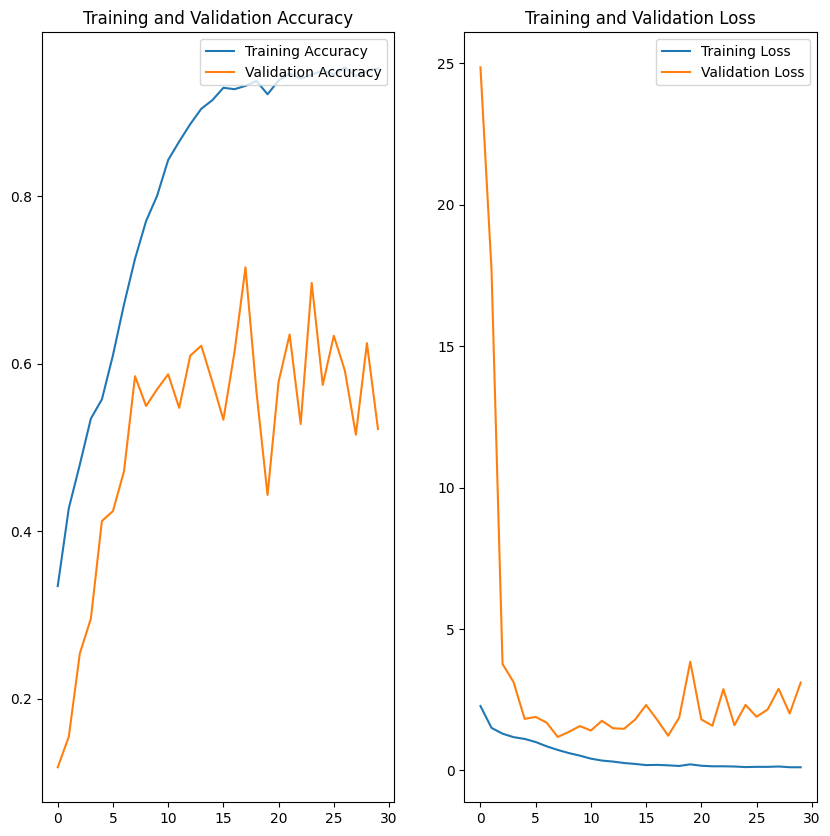

In [126]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(e_range,accu,label='Training Accuracy')
plt.plot(e_range,val_accu,label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(e_range,loss,label='Training Loss')
plt.plot(e_range,val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

The overfitting becomes less than precious model. In addition, the training accuracy and loss are more aligned to the validation accuracy and loss (respectively). For the accuracy chart, we can see that the training and validation data fluctuate almost in the same direction. Whereas, both the training and validation loss show the declining path.
As a result, we almost get rid of overfitting. Class rebalance does help.